#### Linear-Gaussian + Autoregressive Model of Order 1 (LG-AR1)

This notebook provides examples of fitting LG-AR1 model variants:
1. single-session LG-AR1
2. oracle LG-AR1
3. multi-session LG-AR1

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn.metrics import r2_score

path_root = '../src'
sys.path.append(str(path_root))

from models.LG_AR1 import LG_AR1, MultiSession_LG_AR1
seed = 42

#### LOAD DATA
We retrieve pre-computed decoder outputs from previously fitted single-session models. Alternatively, users can apply custom decoders to generate the required inputs for the LG-AR1 model:
1. `gt`: ground truth behavior over sequential trials in each session, e.g., scalar prior `[0.1, 0.9, 0.84, 0.05, ...]`
2. `decoder_output`: single-session decoder output over sequential trials in each session, e.g., predicted prior `[0.15, 0.87, 0.83, 0.07, ...]`

In [2]:
behavior = "prior"
brain_region = "ca1"
data_path = Path("../data/example_decoder_outputs")
pids = [pid for pid in os.listdir(data_path) if os.path.exists(data_path/pid/behavior)]

In [3]:
gt_lst, decoder_output_lst = [], []

for _, pid in enumerate(pids):

    gt, decoder_output, trial_idx = [], [], []
    # Load data from 5 cross-validated folds
    for fold_idx in range(1,5+1):
        gt.append(
            np.load(
                data_path/pid/behavior/brain_region/"y_obs"/f"fold_{fold_idx}.npy", allow_pickle=True
            ).item()["thresholded"]
        )
        decoder_output.append(
            np.load(
                data_path/pid/behavior/brain_region/"y_pred"/f"fold_{fold_idx}.npy", allow_pickle=True
            ).item()["thresholded"]
        )
        trial_idx.append(
            np.load(
                data_path/pid/behavior/brain_region/"trial_idx"/f"fold_{fold_idx}.npy", allow_pickle=True
            )
        )
    sorted_trial_idx = np.argsort(np.concatenate(trial_idx))
    gt = np.concatenate(gt)[sorted_trial_idx]
    decoder_output = np.concatenate(decoder_output)[sorted_trial_idx]
    gt_lst.append(gt)
    decoder_output_lst.append(decoder_output)
    
gt_lst = np.array(gt_lst, dtype=object)
decoder_output_lst = np.array(decoder_output_lst, dtype=object)

#### SINGLE-SESSION LG-AR1
This model learns parameters only from `decoder_output` in the test session. 

In [4]:
test_idx = 4
test_pid = pids[test_idx] # example
test_decoder_output = decoder_output_lst[test_idx]
test_gt = gt_lst[test_idx]
print(f"Apply LG-AR1 to improve decoder outputs from region {brain_region} and session {test_pid}.")

Apply LG-AR1 to improve decoder outputs from region ca1 and session 523f8301-4f56-4faf-ab33-a9ff11331118.


In [5]:
"""
NOTE: If the original decoder outputs are of poor quality, 
      set "is_low_snr" to be True, otherwise False.
"""
lg_ar1 = LG_AR1()
single_sess_pred, single_sess_rho, single_sess_theta, single_sess_mu = lg_ar1.forward(
    test_decoder_output, is_low_snr=True, n_samples=1000
) 
print('-------------------')
print('Original decoding R2 (before single-session LG-AR1): ', r2_score(test_gt, test_decoder_output))
print('Improved decoding R2 (after single-session LG-AR1): ', r2_score(test_gt, single_sess_pred))

/home/yizi/neural_decoding/notebooks/../src/models/LG_AR1.py:50: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n_samples, target_accept=0.95, tune=n_samples//10)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state, theta, mu, eps, xi, rho]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 72 seconds.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.907153245131165, but should be close to 0.95. Try to increase the number of tuning steps.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.878383424921651, but should be close to 0.95. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9014805740898492, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated n

-------------------
Original decoding R2 (before single-session LG-AR1):  0.05161053911493674
Improved decoding R2 (after single-session LG-AR1):  0.2713768548234302


#### ORACLE LG-AR1
This model learns parameters only from `gt` in the test session ("Oracle" means that we have access to the ground truth). 

In [6]:
lg_ar1 = LG_AR1()
oracle_pred, oracle_rho, oracle_theta, oracle_mu = lg_ar1.forward(
    test_gt, is_low_snr=True, n_samples=1000
) 
print('-------------------')
print('Original decoding R2 (before oracle LG-AR1): ', r2_score(test_gt, test_decoder_output))
print('Improved decoding R2 (after oracle LG-AR1): ', r2_score(test_gt, oracle_pred))

/home/yizi/neural_decoding/notebooks/../src/models/LG_AR1.py:50: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n_samples, target_accept=0.95, tune=n_samples//10)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state, theta, mu, eps, xi, rho]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 51 seconds.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7632941947596866, but should be close to 0.95. Try to increase the number of tuning steps.
There were 319 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7052688324157524, but should be close to 0.95. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


-------------------
Original decoding R2 (before oracle LG-AR1):  0.05161053911493674
Improved decoding R2 (after oracle LG-AR1):  0.9994212110062457


#### Multi-Session LG-AR1
This model learns parameters from `gt` in multiple training sessions and then uses such empirical prior information to fit a new LG-AR1 on `decoder_output` in the test session for inference. 

In [7]:
# Prepare training and test data
train_idxs = np.delete(np.arange(len(pids)), test_idx)
train_gt, test_gt = gt_lst[train_idxs], gt_lst[test_idx]
train_decoder_output = decoder_output_lst[train_idxs]

In [9]:
lg_ar1 = MultiSession_LG_AR1()
multi_sess_pred, multi_sess_rho, multi_sess_theta, multi_sess_mu = lg_ar1.forward(
    test_decoder_output, train_decoder_output, train_gt, n_samples=1000, is_low_snr=True
)
print('-------------------')
print('Original decoding R2 (before multi-session LG-AR1): ', r2_score(test_gt, test_decoder_output))
print('Improved decoding R2 (after multi-session LG-AR1): ', r2_score(test_gt, multi_sess_pred))

/home/yizi/neural_decoding/notebooks/../src/models/LG_AR1.py:103: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n_samples, target_accept=0.95, tune=n_samples//10)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, mu, eps, xi, rho]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.


/home/yizi/neural_decoding/notebooks/../src/models/LG_AR1.py:132: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n_samples, target_accept=0.95, tune=n_samples//10)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 16 seconds.


-------------------
Original decoding R2 (before multi-session LG-AR1):  0.05161053911493674
Improved decoding R2 (after multi-session LG-AR1):  0.3409729338122005


#### Visualization

In [18]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 12
BIGGER_SIZE = 12
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.5)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=BIGGER_SIZE)
plt.rc('figure', titlesize=3)
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.major.size'] = 0
plt.rcParams['ytick.minor.size'] = 0

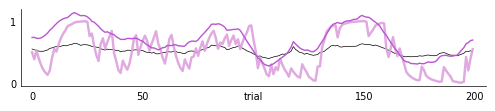

In [19]:
# Visualization of improved decoder outputs

fig, ax = plt.subplots(1,1,figsize=(6, 1))
ax.plot(single_sess_pred[:200], color="k", linewidth=.5, label=f"single-session")
ax.plot(oracle_pred[:200], color="plum", linewidth=1.75, alpha=.9, label="oracle")
ax.plot(multi_sess_pred[:200], color="mediumorchid", linewidth=1., label="multi-session")
ax.set_xlim(-5, 205)
ax.set_yticks([0, 1], [0, 1], fontsize=7)
ax.set_xticks([0, 50, 100, 150, 200], [0, 50, "trial", 150, 200],fontsize=7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [20]:
param_types = (r"$\rho$", r"$\theta$", r"$\mu$")
ssm_params = {
    "oracle": (oracle_rho, oracle_theta, oracle_mu),
    "single-session": (single_sess_rho, single_sess_theta, single_sess_mu),
    "multi-session": (multi_sess_rho, multi_sess_theta, multi_sess_mu)
}
x = np.arange(len(param_types))  
width = 0.25  
multiplier = 0
colors = ["plum", "k", "mediumorchid"]

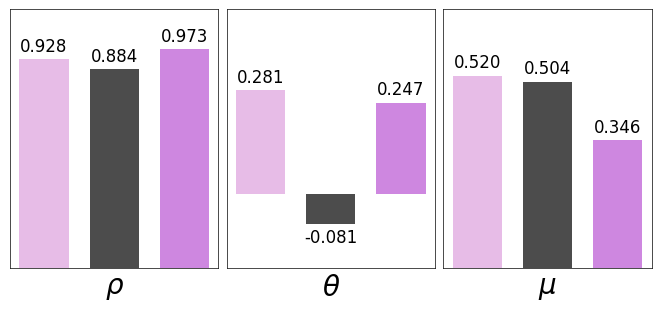

In [24]:
# Visualization of LG-AR1 model parameters

fig, axes = plt.subplots(1,3,layout='constrained', figsize=(6.5, 3))

params = [oracle_rho, single_sess_rho, multi_sess_rho]
rects = axes[0].bar(np.arange(3), params, color=colors, width=0.7, alpha=.7)
axes[0].bar_label(rects, padding=3, labels=[f"{p:.3f}" for p in params])
axes[0].set_yticks([])
axes[0].set_ylim(0, 1.15)
axes[0].set_xticks([0,1,2], ["", r"$\rho$", ""], fontsize=20)

params = [oracle_theta, single_sess_theta, multi_sess_theta]
rects = axes[1].bar(np.arange(3), params, color=colors, width=0.7, alpha=.7)
axes[1].bar_label(rects, padding=3, labels=[f"{p:.3f}" for p in params])
axes[1].set_yticks([])
axes[1].set_ylim(-0.2, 0.5)
axes[1].set_xticks([0,1,2], ["", r"$\theta$", ""], fontsize=20)

params = [oracle_mu, single_sess_mu, multi_sess_mu]
rects = axes[2].bar(np.arange(3), params, color=colors, width=0.7, alpha=.7)
axes[2].bar_label(rects, padding=3, labels=[f"{p:.3f}" for p in params])
axes[2].set_yticks([])
axes[2].set_ylim(0, 0.7)
axes[2].set_xticks([0,1,2], ["", r"$\mu$", ""], fontsize=20)
plt.show()